In [1]:
from collections import defaultdict
import numpy as np
from utils.gridworld import GridWorld

- experiences/memory
    - 经验是一系列关于状态、行动和奖励（$s,a,r$）的数据；

### MC eval (策略评估)

- 只做 $V(s)$ 的更新

In [2]:
class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

In [3]:
env = GridWorld()
agent = RandomAgent()

In [4]:
episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break

        state = next_state

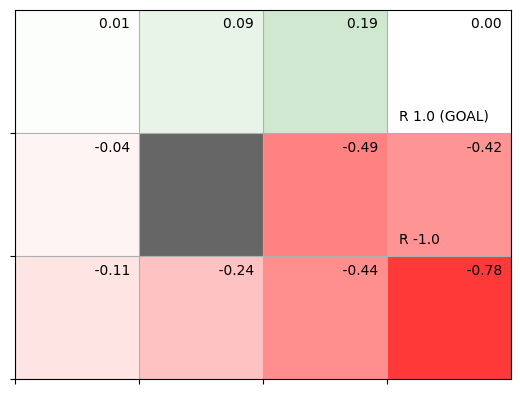

In [5]:
env.render_v(agent.V)

### MC 策略控制

- 评估阶段，对策略评估以获得价值函数
- 改进阶段，通过价值函数的贪心化来改进策略；
- 交替重复这两个过程，以逐渐逼近最优策略和最优价值函数

In [6]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


In [7]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [8]:
from tqdm import tqdm

In [9]:
env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in tqdm(range(episodes)):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

100%|██████████| 10000/10000 [00:02<00:00, 4947.97it/s]


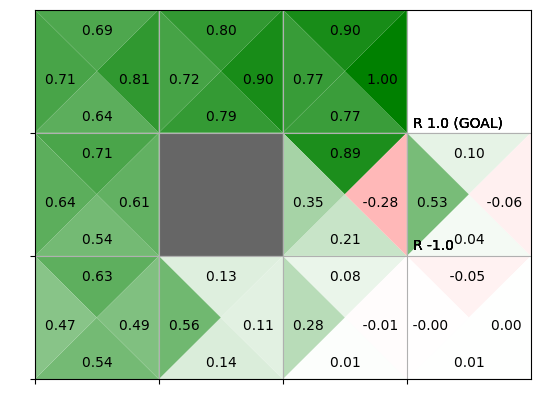

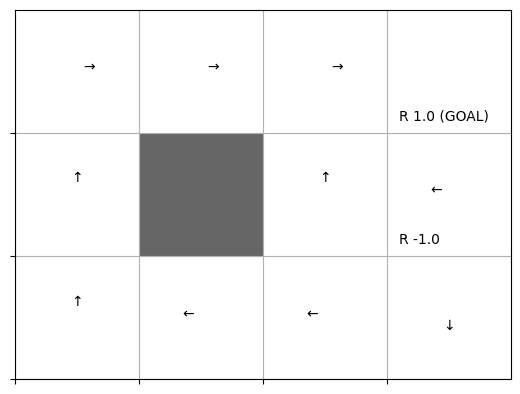

In [10]:
env.render_q(agent.Q)